<a href="https://colab.research.google.com/github/enricoaquilina/webnlg2023/blob/main/WebNLG_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%%capture
!pip install sentencepiece
!pip install transformers
!pip install timm

In [3]:
import gc
import pandas as pd
import os
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers.optimization import  Adafactor 
import time
import warnings
warnings.filterwarnings('ignore')
import os


In [6]:
if torch.cuda.is_available():
   dev = torch.device("cuda:0")
   print("Running on the GPU")
else:
   dev = torch.device("cpu")
   print("Running on the CPU")

Running on the GPU


# Pre-training

## Load dataset

In [9]:
import math
train_df = pd.read_csv('/content/drive/MyDrive/WebNLG/2023-Challenge/data/processed/webNLG2020_train.csv', index_col=[0])
train_df=train_df.iloc[:4500,:]
train_df=train_df.sample(frac=1)
batch_size=8
num_of_batches=math.floor(len(train_df)/batch_size)

In [10]:
num_of_batches

562

In [11]:
train_df.shape

(4500, 3)

In [12]:
train_df

,prefix,input_text,target_text
2765,webNLG,['AFC_Ajax_(amateurs) | ground | Sportpark_De_...,['L-art tal-AFC Ajax (amateurs) huwa Sportpark...
1930,webNLG,['Bionico | ingredient | Granola'],['Bionico jeħtieġ granola bħala wieħed mill-in...
120,webNLG,"['Amsterdam_Airport_Schiphol | runwayName | ""1...",['L-isem tal-runway tal-Ajruport ta’ Amsterdam...
2870,webNLG,['Michele_Marcolini | club | A.C._Lumezzane'],['Michele Marcolini huwa mehmuż mal-klub AC Lu...
238,webNLG,['Iraq | leader | Fuad_Masum'],"['L-Iraq huwa mmexxija minn Fuad Masum.', 'Il-..."
...,...,...,...
1273,webNLG,['1097_Vicia | escapeVelocity | 0.0112 (kilome...,['1097 Vicia għandha veloċità ta ’ ħruġ ta ’ 0...
2813,webNLG,['Dave_Challinor | club | A.F.C._Fylde'],['Dave Challinor huwa logħob fl-A.F.C. Fylde ....
2511,webNLG,['Albert_B._White | deathYear | 1941'],['Is-sena tal-mewt ta’ Albert B. White kien fl...
1277,webNLG,['1097_Vicia | periapsis | 279142000000.0'],['1097 Vicia għandha perijażi ta ’ 27914200000...


In [14]:
%%capture
import pandas as pd
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration,Adafactor

tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base',
                                             return_dict=True)
#moving the model to device(GPU/CPU)
model.to(dev)

In [15]:
optimizer = Adafactor(
    model.parameters(),
    lr=1e-3,
    eps=(1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.8,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False
)


In [16]:
from IPython.display import HTML, display

def progress(loss,value, max=100):
    return HTML(""" Batch loss :{loss}
        
            {value}
        
    """.format(loss=loss,value=value, max=max))

In [17]:
num_of_epochs=10


## Initiate training

In [18]:
#Sets the module in training mode
model.train()

loss_per_10_steps=[]
for epoch in range(1,num_of_epochs+1):
  print('Running epoch: {}'.format(epoch))
  
  running_loss=0

  out = display(progress(1, num_of_batches+1), display_id=True)
  for i in range(num_of_batches):

    inputbatch=[]
    labelbatch=[]
    new_df=train_df[i*batch_size:i*batch_size+batch_size]
    for indx,row in new_df.iterrows():
      input = 'WebNLG: '+row['input_text']+'</s>' 
      labels = row['target_text']+'</s>'    
      inputbatch.append(input)
      labelbatch.append(labels)
    # inputbatch=tokenizer.batch_encode_plus(inputbatch,padding=True,max_length=1000,return_tensors='pt')["input_ids"]
    # labelbatch=tokenizer.batch_encode_plus(labelbatch,padding=True,max_length=1000,return_tensors="pt") ["input_ids"]
    inputbatch=tokenizer.batch_encode_plus(inputbatch,padding=True,return_tensors='pt')["input_ids"]
    labelbatch=tokenizer.batch_encode_plus(labelbatch,padding=True,return_tensors="pt") ["input_ids"]
    inputbatch=inputbatch.to(dev)
    labelbatch=labelbatch.to(dev)

    # clear out the gradients of all Variables 
    optimizer.zero_grad()

    # Forward propogation
    outputs = model(input_ids=inputbatch, labels=labelbatch)
    loss = outputs.loss
    loss_num=loss.item()
    logits = outputs.logits
    running_loss+=loss_num
    if i%10 ==0:      
      loss_per_10_steps.append(loss_num)
    out.update(progress(loss_num,i, num_of_batches+1))

    # calculating the gradients
    loss.backward()

    #updating the params
    optimizer.step()
  
  running_loss=running_loss/int(num_of_batches)
  print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))
  

Running epoch: 1


Epoch: 1 , Running loss: 0.6528816649763185
Running epoch: 2


Epoch: 2 , Running loss: 0.36271503443077363
Running epoch: 3


Epoch: 3 , Running loss: 0.2781799410161599
Running epoch: 4


Epoch: 4 , Running loss: 0.22834672919371798
Running epoch: 5


Epoch: 5 , Running loss: 0.19309015536276472
Running epoch: 6


Epoch: 6 , Running loss: 0.17282545266944743
Running epoch: 7


Epoch: 7 , Running loss: 0.1414225565077359
Running epoch: 8


Epoch: 8 , Running loss: 0.12715830162061492
Running epoch: 9


Epoch: 9 , Running loss: 0.11664431291595896
Running epoch: 10


Epoch: 10 , Running loss: 0.10804722482650093


## Plot loss

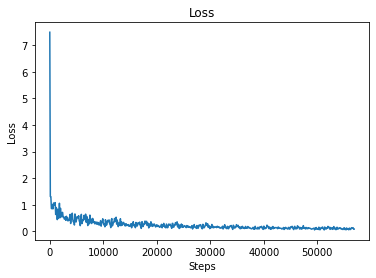

In [19]:
import matplotlib.pyplot as plt
   
steps = [i*100 for i in range(len(loss_per_10_steps))]
  
plt.plot(steps, loss_per_10_steps)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

## Test model

In [20]:
model.eval()
input_ids = tokenizer.encode("WebNLG: Russia | leader | Putin </s>", return_tensors="pt")  # Batch size 1
input_ids=input_ids.to(dev)
outputs = model.generate(input_ids)
tokenizer.decode(outputs[0], skip_special_tokens=True).replace('[','').replace('','')
     

"'Il-mexxej tar-Russja hu"

# Load pre-trained model from HF

In [4]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("eaqui/T5_webnlg")

model = AutoModelForSeq2SeqLM.from_pretrained("eaqui/T5_webnlg")

In [25]:
# model.to(dev)
model.eval()
input_ids = tokenizer.encode("WebNLG: Russia | leader | Putin</s>", return_tensors="pt")  # Batch size 1
# input_ids=input_ids.to(dev)
outputs = model.generate(input_ids.to(dev))
tokenizer.decode(outputs[0], skip_special_tokens=True).replace('[','').replace("'","")

'Il-mexxej tar-Russja hu'

In [28]:
def generate(text):
  # model.to(dev)
  model.eval()
  input_ids = tokenizer.encode("WebNLG:{} ".format(text), return_tensors="pt")  # Batch size 1
  s = time.time()
  outputs = model.generate(input_ids.to(dev))
  gen_text=tokenizer.decode(outputs[0], skip_special_tokens=True).replace('[','').replace("'","")
  elapsed = time.time() - s
  print('Generated in {} seconds'.format(str(elapsed)[:4]))

  return gen_text

In [30]:
generate(' Russia | leader | Putin')

Generated in 0.27 seconds


'Il-mexxej tar-Russja hu'

In [31]:
generate('Sidhath | profession | Doctor  && Sidharth | home_town |  Bombay')

Generated in 0.26 seconds


'"Sidhath huwa fil-belt ta'

In [32]:
generate('Nie_Haisheng | birthDate | 1964-10-13  && Nie_Haisheng | occupation | Fighter_pilot ')

Generated in 0.27 seconds


'Nie Haisheng twieled fit-13 ta’ Ott'

In [33]:
generate('Bananaman | creator | Steve_Bright &&  Bananaman | broadcastedBy | BBC')

Generated in 0.30 seconds


'Steve Bright u l-bananaman jii'

In [34]:
generate('Bananaman | lastAired | "1986-04-15" && Bananaman | creator | Steve_Bright')

Generated in 0.39 seconds


'Steve Bright huwa l-olqien'

In [35]:
generate('Alan_B._Miller_Hall | currentTenants | Mason_School_of_Business && Alan_B._Miller_Hall | location | Williamsburg,_Virginia')

Generated in 0.27 seconds


'"L-Iskola Mason of Business &&&Alan B Miller'

# Quantization

In [36]:
import torch.quantization
import torch.nn as nn

quantized_model = torch.quantization.quantize_dynamic(
    model, {nn.Linear,nn.Dropout,nn.LayerNorm}, dtype=torch.qint8
)


In [37]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

print_size_of_model(model)
print_size_of_model(quantized_model)

Size (MB): 891.71583
Size (MB): 322.003751


In [40]:
def quant_generate(text):
  quantized_model.eval()
  input_ids = tokenizer.encode("WebNLG:{} ".format(text), return_tensors="pt")  # Batch size 1
  s = time.time()
  outputs = quantized_model.generate(input_ids.to(dev))
  gen_text=tokenizer.decode(outputs[0]).replace('','').replace('','')
  elapsed = time.time() - s
  print('Generated in {} seconds'.format(str(elapsed)[:4]))

  
  return gen_text

In [42]:
# quant_generate('Facebook | CEO | Mark  && Facebook | number Of Employees | 52000 ')

In [ ]:
generate('Facebook | CEO | Mark  && Facebook | number Of Employees | 52000 ')

# Upload model to Hub

In [22]:
from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [23]:
model.push_to_hub("eaqui/T5_webnlg")
tokenizer.push_to_hub('T5_webnlg')
# torch.save(model.state_dict(),'pytorch_model.bin')

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/eaqui/T5_webnlg/commit/78585142c9635e63040fb00d7d18326e11f6235b', commit_message='Upload tokenizer', commit_description='', oid='78585142c9635e63040fb00d7d18326e11f6235b', pr_url=None, pr_revision=None, pr_num=None)